# Titanic: Machine Learning from Disaster

This notebook is about the [Titanic Challenge](https://www.kaggle.com/c/titanic)

### Preps

In [11]:
# imports
import pandas as pd
import numpy as np
import random
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [2]:
# functions I'll be using

def turn_factors_2_columns(df, target_col):
    "transforms one column of categorical data in several other columns with dummy values"
    if target_col not in df.columns:
        print('{} not found in data'.format(target_col))
        return df
    # saving observed values possibilities
    possibilities = list(set([x if not pd.isnull(x)  else 'unkn' for x in df[target_col].values]))
    # creating dummies columns
    cat_df = pd.get_dummies(df[target_col], prefix=target_col)
    if sum(cat_df.apply('sum', axis=1).values) < cat_df.shape[0]:
        cat_df['_'.join([target_col,'unkn'])] = cat_df.apply(lambda x: abs(sum(x)-1), axis=1).values
    df2 = df.join(cat_df).copy()
    df2.drop(target_col, axis=1, inplace=True)
    # verifying if there is any missing possibility
    global CAT_VARS_GLOBAL
    if target_col in CAT_VARS_GLOBAL.keys():
        # printing if there is unconsistencies (var present in test data and not in train)
        for x in possibilities:
            if x not in CAT_VARS_GLOBAL[target_col]:
                print('found new value in this set of data: {}'.format(str(x)))
        # adding values to global archive - to use next time
        CAT_VARS_GLOBAL[target_col] = list(set(CAT_VARS_GLOBAL[target_col] + possibilities))
        # adding missing columns if it's the case
        for it in CAT_VARS_GLOBAL[target_col]:
            if '_'.join([target_col,it]) not in df2.columns:
                df2['_'.join([target_col,it])] = 0
    else:
        # adding values to global archive - to use next time
        CAT_VARS_GLOBAL[target_col] = possibilities
    return df2


def substrings_in_string(big_string, substrings):
    "finds the first substring in the big string"
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return 'unkn'


def replace_titles(x):
    "groups several titles to the more usual ones"
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title


def prepare_data(df):
    "creates new variables and transforms categorical data into numeric"
    df.index = df['PassengerId']
    df.drop('PassengerId', axis=1, inplace=True)
    # coudnt make an use of this column
    df.drop('Ticket', axis=1, inplace=True)
    # PCLASS : I believe this variable does not have a numerical meaning
    replace_dict_pclass = {1:'fir', 2:'sec', 3:'thi'}
    df['Pclass'] = df['Pclass'].replace(replace_dict_pclass)
    df = turn_factors_2_columns(df=df, target_col='Pclass')
    # TITLE
    title_list = ['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                  'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                  'Don', 'Jonkheer']
    df['Title']=df['Name'].map(lambda x: substrings_in_string(x, title_list))
    df.drop('Name', axis=1, inplace=True)
    df['Title'] = df.apply(replace_titles, axis=1)
    df = turn_factors_2_columns(df=df, target_col='Title')
    # SEX
    if 'Sex' in df.columns:
        df = turn_factors_2_columns(df=df, target_col='Sex')
    # since is binary we don't need two columns
    df.drop('Sex_male', axis=1, inplace=True)
    # turning cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G','unkn']
    df['Deck'] = df['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
    df.drop('Cabin', axis=1, inplace=True)
    df = turn_factors_2_columns(df=df, target_col='Deck')
    # embarked
    df = turn_factors_2_columns(df=df, target_col='Embarked')
    # new random variable
    df['Family_Size']=df['SibSp']+df['Parch']
    return df


def separate_xy(df, y_col):
    "transform dataframe into numpy arrays better suited to ML APIs"
    df_vars=df.columns.values.tolist()
    y_var=[y_col]
    X_vars=[i for i in df_vars if i not in y_var]
    return (df[X_vars].values, df[y_var].values)


def plot_model_eval(model_history, acc='acc', loss='loss'):
    "plot keras model accuracy and loss information"
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(12,7))
    ax1.plot(model_history.history[acc])
    ax1.plot(model_history.history['val_{}'.format(acc)])
    # ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    # ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='lower right')
    ax2.plot(model_history.history[loss])
    ax2.plot(model_history.history['val_{}'.format(loss)])
    # ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper right')
    plt.show()

    

### Loading Data

In [3]:
# reading data
CAT_VARS_GLOBAL = {}
train_data_raw = pd.read_csv('data/kaggle_titanic_train.csv')
test_data_raw = pd.read_csv('data/kaggle_titanic_test.csv')

In [4]:
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There is some categorical data, and some new features we can extract from columns, so we just do that.

In [5]:
train_data = prepare_data(df=train_data_raw.copy())
test_data = prepare_data(df=test_data_raw.copy())

In [6]:
train_data.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_fir,Pclass_sec,Pclass_thi,Title_Master,Title_Miss,...,Deck_E,Deck_F,Deck_G,Deck_T,Deck_unkn,Embarked_C,Embarked_Q,Embarked_S,Embarked_unkn,Family_Size
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1
2,1,38.0,1,0,71.2833,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,1,26.0,0,0,7.9250,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0
4,1,35.0,1,0,53.1000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,0,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


Next we look for missing data, a common problem

In [7]:
# verifying for missing data
print('train dataset')
for col in train_data.columns:
    num_null_values = sum(pd.isnull(train_data[col].values))
    if num_null_values > 0:
        print('    {} : {} null values'.format(col, str(num_null_values)))
print('test dataset')
for col in test_data.columns:
    num_null_values = sum(pd.isnull(test_data[col].values))
    if num_null_values > 0:
        print('    {} : {} null values'.format(col, str(num_null_values)))

train dataset
    Age : 177 null values
test dataset
    Age : 86 null values
    Fare : 1 null values


This data as it is cannot be used by several models, we can remove the rows with missing data or fill the voids with a value (using a simple method like the average or predicting the values with other models). In this case we just model a simple general linear model (gaussian) to predict the missing data on the "Age" column.

In [12]:
# age variable
all_data = pd.concat([train_data, test_data], sort=False)
age_data = all_data.drop('Survived', axis=1).dropna().copy()
age_data_topred = all_data.loc[pd.isnull(all_data['Age'])].drop(labels=['Survived', 'Age'], axis=1).copy()
(x_age, y_age) = separate_xy(age_data, y_col='Age')
glm_model = sm.GLM(y_age, x_age).fit()
predicted_ages = glm_model.predict(age_data_topred.values)
predicted_ages_df = pd.DataFrame({'Age':predicted_ages}, index=age_data_topred.index)
train_data.update(predicted_ages_df)
test_data.update(predicted_ages_df)

In [13]:
test_data.loc[pd.isnull(test_data['Fare']), 'Fare'] = np.nanmean(all_data['Fare'].values)

### Predicting

In [14]:
# logistic regression
[xs, ys] = separate_xy(train_data, y_col='Survived')
glm_model = sm.Logit(endog=ys, exog=xs).fit(maxiter=600, method='newton')
survived_hat = glm_model.predict(xs)
not_correct = sum(abs((survived_hat > 0.5).astype(int) - ys.reshape(len(ys))))
accuracy = (len(ys)-not_correct)/len(ys)
accuracy

         Current function value: 0.398618
         Iterations: 600


/home/tsk/.virtualenvs/jupyter/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.8417508417508418

In [15]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(min_samples_split=20, max_depth=5)
decision_tree.fit(xs, ys)
Y_pred2 = decision_tree.predict(xs)
decision_tree.score(xs, ys)

0.8496071829405163

In [16]:
# using tensorflow with keras

[xs, ys] = separate_xy(train_data, y_col='Survived')

import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

model1 = Sequential()
model1.add(Dense(units=52, activation='sigmoid', input_dim=xs[0].size))
model1.add(Dense(units=26, activation='sigmoid'))
model1.add(Dense(units=13, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model1.fit(xs, ys, epochs=500, batch_size=240, validation_split=0.2, verbose=0)

model1_eval = model1.evaluate(xs, ys, verbose=0)
print()
print('loss: ', model1_eval[0])
print('metric: ', model1_eval[1])

Using TensorFlow backend.



loss:  0.32690240034685125
metric:  0.8675645337629265


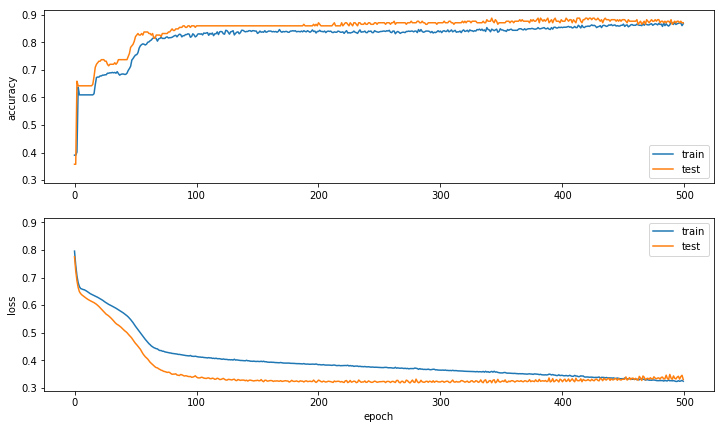

In [17]:
plot_model_eval(model_history=history)

In [ ]:
# saving prediction in kaggle format
competition_nickname = 'titanic'
model_tryout_name = 'decisionTreeSimpleSklearn'
test_labels = decision_tree.predict(test_data)

pred2_list = test_labels.reshape(len(test_labels))
predicted2 = [random.randint(0,1) if pd.isnull(x) else int(x > 0.5) for x in pred2_list]
results_submission = pd.DataFrame({
                                'PassengerId': test_data_raw['PassengerId'].values,
                                'Survived': predicted2
                            })
now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
results_submission.to_csv('submissions/kaggle_{}_submission_{}_{}.csv'.format(competition_nickname, model_tryout_name, now), index=False)